In [1]:
pip install numpy pandas matplotlib scikit-learn scipy

In [ ]:
print(thyroid_data.head())
print(thyroid_data.columns)
print(thyroid_data.index)

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  label
0   0.774194   0.001132   0.137571   0.275701   0.295775   0.236066    0.0
1   0.247312   0.000472   0.279886   0.329439   0.535211   0.173770    0.0
2   0.494624   0.003585   0.222960   0.233645   0.525822   0.124590    0.0
3   0.677419   0.001698   0.156546   0.175234   0.333333   0.136066    0.0
4   0.236559   0.000472   0.241935   0.320093   0.333333   0.247541    0.0
Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'label'],
      dtype='object')
RangeIndex(start=0, stop=3772, step=1)


In [1]:
import numpy as np

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

In [10]:
class KNNAnomalyDetector:
    def __init__(self, k=5, threshold_percentile=95, distance_func=None, external_threshold=None):
        self.k = k
        self.threshold_percentile = threshold_percentile
        self.distance_func = distance_func if distance_func is not None else self.default_distance
        self.external_threshold = external_threshold
        self.threshold_ = None
        self.anomaly_scores_ = None

    def fit(self, X):
        self.n_samples = len(X)
        self.X_train = X.copy()  # save train data copy
        distances = np.zeros((self.n_samples, self.n_samples))

        # compute distance between points
        for i in range(self.n_samples):
            for j in range(i + 1, self.n_samples):
                distances[i, j] = self.distance_func(X[i], X[j])
                distances[j, i] = distances[i, j]

        # find k nearest neighbours
        nearest_neighbors = np.argsort(distances, axis=1)[:, 1:self.k]
        # mean distance from k nearest neighbours
        self.anomaly_scores_ = np.mean(distances[np.arange(self.n_samples)[:, None], nearest_neighbors], axis=1)

        # if there's no threshold given, we determine treshold using percentile
        if self.external_threshold is None:
            self.threshold_ = np.percentile(self.anomaly_scores_, self.threshold_percentile)
        else:
            self.threshold_ = self.external_threshold
        return self

    def predict(self, X, threshold=None):
        # use external threshold if given, otherwise self.threshold_
        if threshold is None:
            threshold = self.threshold_
        scores = self.decision_function(X)
        return scores > threshold

    def decision_function(self, X):
        # proess input data instead of train data
        distances = np.zeros((len(X), len(self.X_train)))
        for i in range(len(X)):
            for j in range(len(self.X_train)):
                distances[i, j] = self.distance_func(X[i], self.X_train[j])

        nearest_neighbors = np.argsort(distances, axis=1)[:, :self.k]
        scores = np.mean(distances[np.arange(len(X))[:, None], nearest_neighbors], axis=1)
        return scores

    @staticmethod
    def default_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

## Thyroid dataset

In [8]:
from sklearn.model_selection import train_test_split
import scipy.io
import pandas as pd
import numpy as np

thyroid_data = pd.read_csv('./thyroid.csv')

train_data, temp_data = train_test_split(thyroid_data, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

In [12]:
import matplotlib.pyplot as plt

X_train = train_data
X_valid = valid_data
X_test = test_data

detector = KNNAnomalyDetector(k=6, distance_func=manhattan_distance)
detector.fit(X_train)
threshold_train = detector.threshold_

anomalies_train = detector.predict(X_train, threshold_train)
scores_train = detector.decision_function(X_train)


anomalies_valid = detector.predict(X_valid, threshold_train)
scores_valid = detector.decision_function(X_valid)

anomalies_test = detector.predict(X_test, threshold_train)
scores_test = detector.decision_function(X_test)


plt.hist(scores_train, bins=30, alpha=0.5, label='Train')
plt.hist(scores_valid, bins=30, alpha=0.5, label='Valid')
plt.hist(scores_test, bins=30, alpha=0.5, label='Test')
plt.axvline(x=threshold_train, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Distribution of Anomaly Scores - Thyroid dataset')
plt.show()

KeyError: 0

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)

X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

X_valid_scaled = scaler.transform(X_valid)
X_valid_pca = pca.transform(X_valid_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


In [36]:
from sklearn.decomposition import PCA

# dimensionality reduction
pca = PCA(n_components=2)
data_pca1 = pca.fit_transform(train_data.iloc[:, :-1])  # last column contains labels

# conversion back to df
train_data_pca_df = pd.DataFrame(data_pca1, columns=['PCA1', 'PCA2'])

data_pca2 = pca.fit_transform(valid_data.iloc[:, :-1])

valid_data_pca_df = pd.DataFrame(data_pca2, columns=['PCA1', 'PCA2'])

data_pca3 = pca.fit_transform(test_data.iloc[:, :-1])

test_data_pca_df = pd.DataFrame(data_pca3, columns=['PCA1', 'PCA2'])

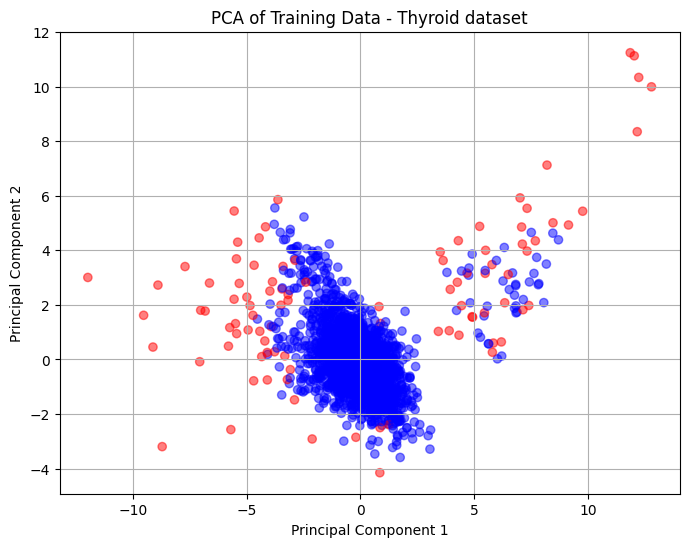

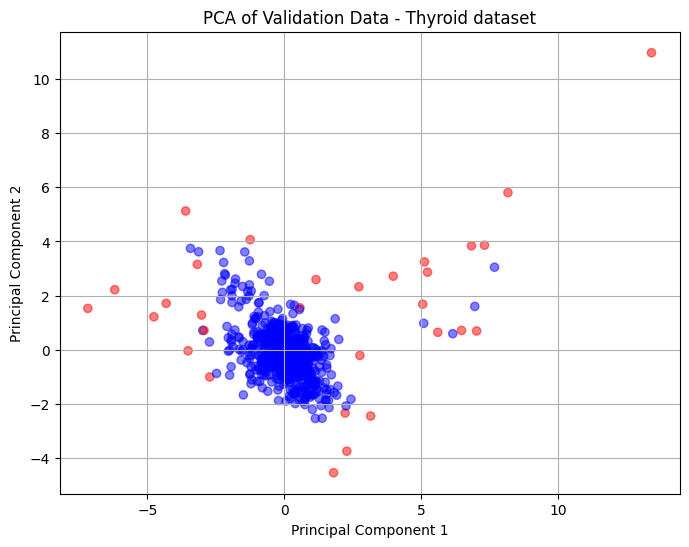

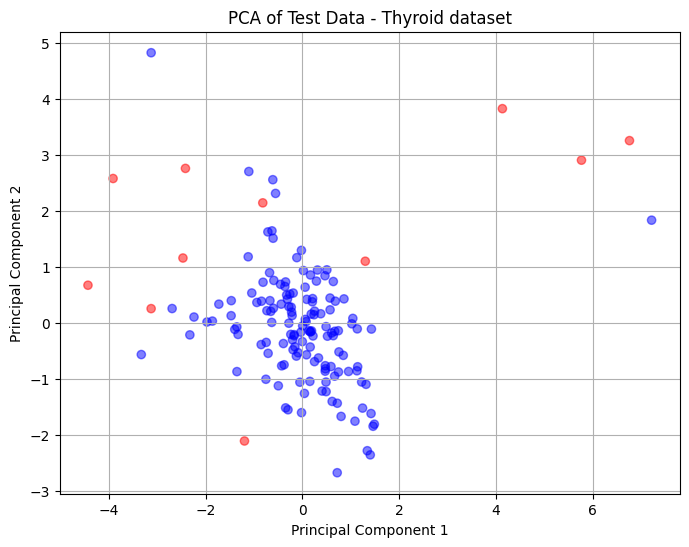

In [37]:
def plot_pca_results(pca_data, anomalies, title):
    colors = ['blue' if x == 0 else 'red' for x in anomalies]

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=colors, alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


plot_pca_results(X_train_pca, anomalies_train, 'PCA of Training Data - Thyroid dataset')
plot_pca_results(X_valid_pca, anomalies_valid, 'PCA of Validation Data - Thyroid dataset')
plot_pca_results(X_test_pca, anomalies_test, 'PCA of Test Data - Thyroid dataset')

## Shuttle dataset

In [38]:
from sklearn.model_selection import train_test_split
import scipy.io
import pandas as pd
import numpy as np

shuttle_data = pd.read_csv('/content/shuttle.csv')

train_data, temp_data = train_test_split(shuttle_data, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.2, random_state=42)

In [40]:
import matplotlib.pyplot as plt

X_train = train_data.values
X_valid = valid_data.values
X_test = test_data.values

detector = KNNAnomalyDetector(k=6, distance_func=manhattan_distance)
detector.fit(X_train)
threshold_train = detector.threshold_

anomalies_train = detector.predict(X_train, threshold_train)
scores_train = detector.decision_function(X_train)


anomalies_valid = detector.predict(X_valid, threshold_train)
scores_valid = detector.decision_function(X_valid)

anomalies_test = detector.predict(X_test, threshold_train)
scores_test = detector.decision_function(X_test)


plt.hist(scores_train, bins=30, alpha=0.5, label='Train')
plt.hist(scores_valid, bins=30, alpha=0.5, label='Valid')
plt.hist(scores_test, bins=30, alpha=0.5, label='Test')
plt.axvline(x=threshold_train, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.title('Distribution of Anomaly Scores - Shuttle dataset')
plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)

X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

X_valid_scaled = scaler.transform(X_valid)
X_valid_pca = pca.transform(X_valid_scaled)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
def plot_pca_results(pca_data, anomalies, title):
    colors = ['blue' if x == 0 else 'red' for x in anomalies]

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=colors, alpha=0.5)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


plot_pca_results(X_train_pca, anomalies_train, 'PCA of Training Data - Shuttle dataset')
plot_pca_results(X_valid_pca, anomalies_valid, 'PCA of Validation Data - Shuttle dataset')
plot_pca_results(X_test_pca, anomalies_test, 'PCA of Test Data - Shuttle dataset')